In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import requests
import zipfile
from tqdm import tqdm

# Get project files
# Download the file
url = "https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip"
response = requests.get(url, stream=True)
file_size = int(response.headers.get('content-length', 0))

print("Downloading cats_and_dogs.zip...")
with open("cats_and_dogs.zip", "wb") as file:
    for data in tqdm(response.iter_content(chunk_size=1024), total=file_size//1024, unit='KB'):
        file.write(data)

# Extract the zip file
print("Extracting files...")
with zipfile.ZipFile("cats_and_dogs.zip", "r") as zip_ref:
    zip_ref.extractall(".")

print("Download and extraction complete!")

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

69046KB [00:02, 34273.40KB/s]                           


Extracting files...
Download and extraction complete!


In [5]:
# 3
# Create an image generator with data augmentation for training
train_image_generator = ImageDataGenerator(
	rescale=1./255,
	rotation_range=40,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.2,
	zoom_range=0.2,
	horizontal_flip=True,
	fill_mode='nearest'
)

# For validation and test data, we only rescale
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Create the data generators
train_data_gen = train_image_generator.flow_from_directory(
	directory=train_dir,
	target_size=(IMG_HEIGHT, IMG_WIDTH),
	batch_size=batch_size,
	class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
	directory=validation_dir,
	target_size=(IMG_HEIGHT, IMG_WIDTH),
	batch_size=batch_size,
)

test_data_gen = test_image_generator.flow_from_directory(
	directory=test_dir,
	target_size=(IMG_HEIGHT, IMG_WIDTH),
	batch_size=batch_size,
	shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


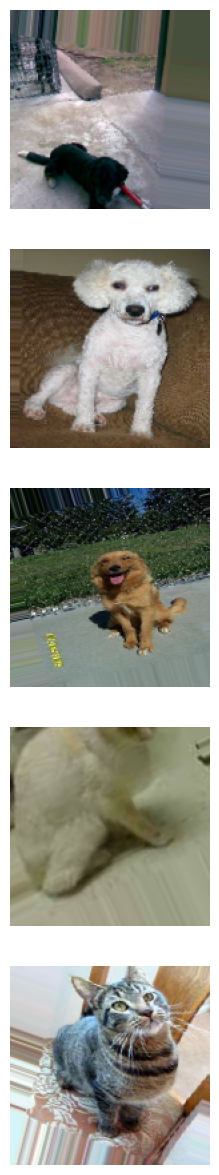

In [6]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
# 5
train_image_generator = None


In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [ ]:
# 7
model = Sequential()








model.summary()

In [ ]:
# 8
history = None

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")